In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree, lax, value_and_grad
jconfig.update("jax_enable_x64", True)
print(jdevices())

# from montecosmo.model import FieldLevelModel, default_config
# from montecosmo.utils import pdump, pload , Path
from pathlib import Path

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /dvs_ro/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

save_dir = Path("./scratch")
# save_dir = Path("/feynman/home/dphp/hs276503/scratch/png/kaiser_test21")
# save_dir = Path("/pscratch/sd/h/hsimfroy/png/kaiser_test21")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[cuda(id=0)]
feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [17]:
from PIL import Image
from matplotlib import animation, rc
# from matplotlib.colors import to_rgba_array
rc('animation', html='html5')

def load_image(im_path, size=None, bg='WHITE', gray=False):
    img = Image.open(im_path).convert('RGBA')
    bg = Image.new('RGBA', img.size, bg)
    img = Image.alpha_composite(bg, img)
        
    if size is not None:
        img = img.resize(size)
    if gray:
        img = img.convert('L')
    return img

def load_mesh(im_path, depth, size=None, bg='WHITE', gray=False, alpha=False, reverse=False):
    img = load_image(im_path, size, bg, gray)
    # display(img)
    img = np.array(img)
    if gray:
        mesh = jnp.broadcast_to(img[::-1].T[...,None], (*img.shape, depth))
    else:
        img = img[...,:4] if alpha else img[..., :3]
        mesh = jnp.broadcast_to(
                    np.moveaxis(img[::-1], 0 ,1)[...,None,:], 
                (*img.shape[:2], depth, img.shape[2]))
    print(f"load {mesh.shape=}")
    mesh = mesh.astype(float) / 255
    if reverse:
        mesh = 1 - mesh
    return mesh

def plot_mesh(mesh, box_shape=None, vlim=1e-4, cmap="gray", reverse=False):
    mesh = np.asarray(mesh)
    mesh_shape = np.array(mesh.shape)
    gray = mesh.ndim == 2
    axids = [0,1]
    
    if box_shape is None:  
        box_shape = mesh_shape
    else:
        box_shape = np.asarray(box_shape)

    if reverse:
        cmap = cmap[:-2] if cmap.endswith('_r') else cmap+'_r'

    (xb, yb), (xm, ym) = box_shape[axids], mesh_shape[axids]
    xs, ys = np.linspace(0, xb, xm, endpoint=False), np.linspace(0, yb, ym, endpoint=False)
    xx, yy = np.meshgrid(xs, ys, indexing='ij')

    if vlim is None:
        vlim = mesh.min(), mesh.max()
    elif isinstance(vlim, float):
        vlim = np.quantile(mesh, [vlim/2, 1-vlim/2])
    vmin, vmax = vlim

    if gray:
        quad = plt.pcolormesh(xx, yy, mesh, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        colors = mesh.reshape(-1, mesh.shape[-1])
        colors = np.clip(1 - (colors - vmin) / (vmax - vmin), 0, 1)
        quad = plt.pcolormesh(xx, yy, mesh[:,:,0], facecolors=colors)
        quad.set_array(None)
    plt.xlabel("$x$ [Mpc/$h$]"), plt.ylabel("$y$ [Mpc/$h$]")
    plt.gca().set_aspect(1)
    return quad

def plot_meshes(meshes, box_shape=None, titles=None, joint_scale=False, 
                vlim=1e-4, cmap="gray", reverse=False):
    meshes = np.asarray(meshes)
    if joint_scale:
        if vlim is None:
            vlim = meshes.min(), meshes.max()
        elif isinstance(vlim, float):
            vlim = np.quantile(meshes, [vlim/2, 1-vlim/2])

    plt.figure(figsize=(5*len(meshes), 5))
    for i_mesh, mesh in enumerate(meshes):
        plt.subplot(1, len(meshes), i_mesh+1)
        plot_mesh(mesh, box_shape, vlim, cmap, reverse)

        if titles is not None:
            plt.title(titles[i_mesh])
        if not joint_scale:
            plt.colorbar()
    plt.tight_layout()

def animate_meshes(meshes, box_shape=None, vlim=1e-4, cmap="gray"):
    meshes = np.asarray(meshes)
    gray = meshes[0].ndim == 2

    if vlim is None:
        vlim = meshes.min(), meshes.max()
    if isinstance(vlim, float):
        vlim = np.quantile(meshes, [vlim/2, 1-vlim/2])
    vmin, vmax = vlim
    
    plt.gcf().add_axes([0, 0, 1, 1])
    quad = plot_mesh(meshes[0], box_shape, vlim, cmap)
    # plt.colorbar()
    plt.axis(False)

    def update(i):
        if i < len(meshes):
            if gray:
                quad.set_array(meshes[i])
            else:
                colors = meshes[i].reshape(-1, 3)
                colors = np.clip(1 - (colors - vmin) / (vmax - vmin), 0, 1)
                quad.set_facecolor(colors)
        return quad,

    anim = animation.FuncAnimation(plt.gcf(), update, frames=len(meshes)+10, interval=100, blit=True)
    plt.close()
    display(anim)
    return anim

load mesh.shape=(384, 384, 8)


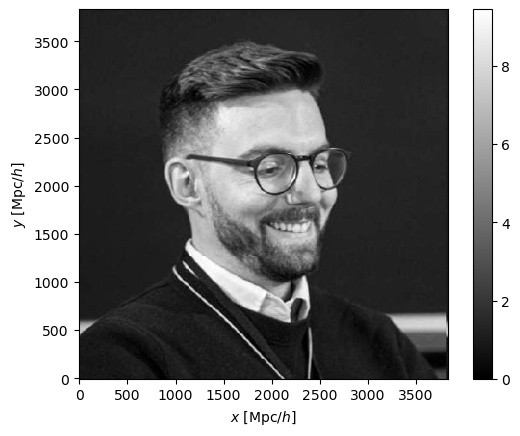

In [23]:
# !wget -nc https://raw.githubusercontent.com/hsimonfroy/talks/main/2024CoPhy/BaoBan.png
# im_path = "./BaoBan.png"
im_path = "./EiffL.jpg"
reverse = False
# obs_mesh = load_mesh(im_path, depth=16, size=(256,256), gray=True, reverse=reverse) * 10
obs_mesh = load_mesh(im_path, depth=8, size=(384,384), gray=True, reverse=reverse) * 10
# obs_mesh = load_mesh(im_path, depth=16, size=(64,64), gray=True, reverse=reverse) * 10

config = {
    'mesh_shape': obs_mesh.shape[:3],
    'box_shape': np.array(obs_mesh.shape[:3]) * 10, # in Mpc/h
    'a_obs': 1.,
    'std_obs': 1.,
    'n_steps': 5,
    'snapshots': 30,
}

plot_mesh(obs_mesh.mean(2), config['box_shape'], reverse=reverse)
plt.colorbar()
# plt.axis(False)

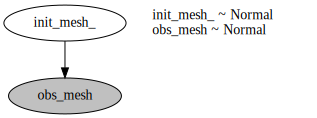

In [24]:
from montecosmo.bricks import Planck18, lin_power_mesh, regular_pos, get_scaled_shape
from montecosmo.utils import rg2cgh, chreshape, ch2rshape, r2chshape
from montecosmo.nbody import nbody_bf, paint, interlace
from numpyro import distributions as dist, sample, render_model, handlers

rg2cgh = jnp.fft.rfftn
oversamp = 1.5

# def fourier_reshape(mesh, oversamp):
#     mesh_shape = ch2rshape(mesh.shape)
#     shape = r2chshape(get_scaled_shape(mesh_shape, oversamp))
#     return chreshape(mesh, shape)

def model(mesh_shape, box_shape, a_obs=1., std_obs=1., n_steps=30, snapshots=None, 
          paint_order=2, interlace_order=2, deconv=False):
    cosmo = Planck18()
    pmesh = lin_power_mesh(cosmo, mesh_shape, box_shape)
    init_mesh_ = sample('init_mesh_', dist.Normal(0, 1).expand(mesh_shape))
    
    init_mesh = rg2cgh(init_mesh_)
    init_mesh *= pmesh**.5
    chshape = init_mesh.shape
    ptcl_shape = get_scaled_shape(mesh_shape, oversamp)
    init_mesh = chreshape(init_mesh, r2chshape(ptcl_shape))
    pos = regular_pos(ptcl_shape)

    cosmo._workspace = {}
    def save_mean_mesh(t, y, args):
        pos, vel = y
        mesh = interlace(pos, ptcl_shape, paint_order=paint_order, interlace_order=interlace_order, deconv=deconv)
        mesh = chreshape(mesh, chshape)
        mesh = jnp.fft.irfftn(mesh)
        return mesh.mean(-1)

    out = nbody_bf(cosmo, init_mesh=init_mesh, pos=pos, a=a_obs, n_steps=n_steps, 
                        paint_order=2, snapshots=snapshots, fn=save_mean_mesh)
    
    if isinstance(out, tuple):
        pos, vel = tree.map(lambda x: x[-1], out)
        pm_mesh = interlace(pos, ptcl_shape, paint_order=paint_order, interlace_order=interlace_order, deconv=deconv)
        pm_mesh = chreshape(pm_mesh, chshape)
        pm_mesh = jnp.fft.irfftn(pm_mesh)
        return sample('obs_mesh', dist.Normal(pm_mesh, std_obs))
    else:
        return out


obs_model = handlers.condition(partial(model, **config | {'snapshots': None}), 
                               data={'obs_mesh': obs_mesh})
display(render_model(obs_model, render_distributions=True, render_params=True))

from numpyro.infer.util import log_density
potential = lambda params: -log_density(obs_model, (), {}, params)[0]
potential_valgrad = jit(value_and_grad(potential))

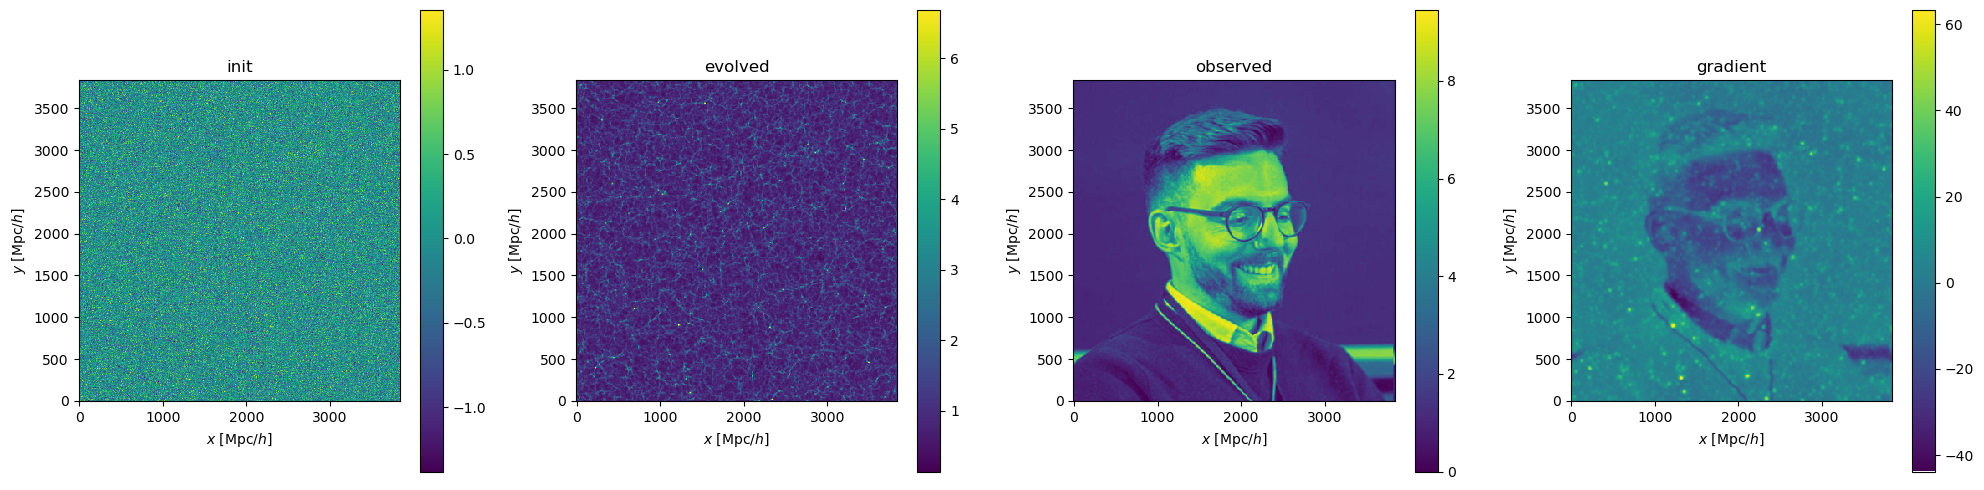

In [25]:
def plot_optim_state(params):
    pm_meshes = handlers.condition(obs_model, params)(**config)
    plt.figure(figsize=(5, 5))
    anim = animate_meshes(pm_meshes, config['box_shape'])
    # plot_meshes(meshes, config['box_shape'], joint_scale=True)

    init_mesh = jnp.fft.irfftn(rg2cgh(params['init_mesh_']))
    pot_grad = potential_valgrad(params)[1]['init_mesh_']
    pot_grad = jnp.fft.irfftn(rg2cgh(pot_grad))

    meshes = jnp.stack([init_mesh.mean(2), 
                        pm_meshes[-1], 
                        obs_mesh.mean(2), 
                        pot_grad.mean(2)])
    titles = ['init', 'evolved', 'observed', 'gradient']
    plot_meshes(meshes, config['box_shape'], titles, cmap='viridis')
    return anim, pm_meshes[-1]

start_params = {'init_mesh_': jr.normal(jr.key(0), config['mesh_shape'])}
anim, pm_mesh = plot_optim_state(start_params)

In [26]:
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
lr0 = .1
n_epochs = 700
energies = []

lr_fn = lambda i: lr0 / (1 + i)**.5
opt_init, opt_update, get_params = adam(lr_fn)
opt_state = opt_init(start_params)

def step(step, opt_state):
    value, pot_grad = potential_valgrad(get_params(opt_state))
    opt_state = opt_update(step, pot_grad, opt_state)
    return value, opt_state

for i_epoch in tqdm(range(n_epochs)):
    value, opt_state = step(i_epoch, opt_state)
    energies.append(float(value))
params = get_params(opt_state)

  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 700/700 [07:48<00:00,  1.49it/s]


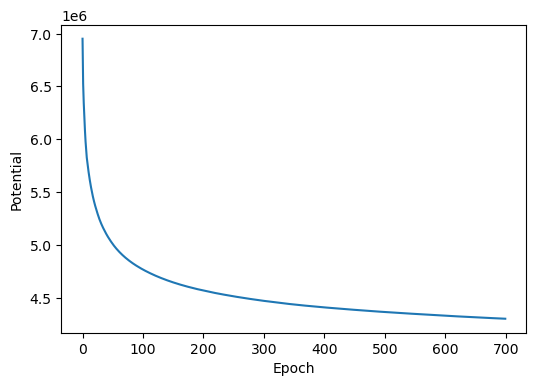

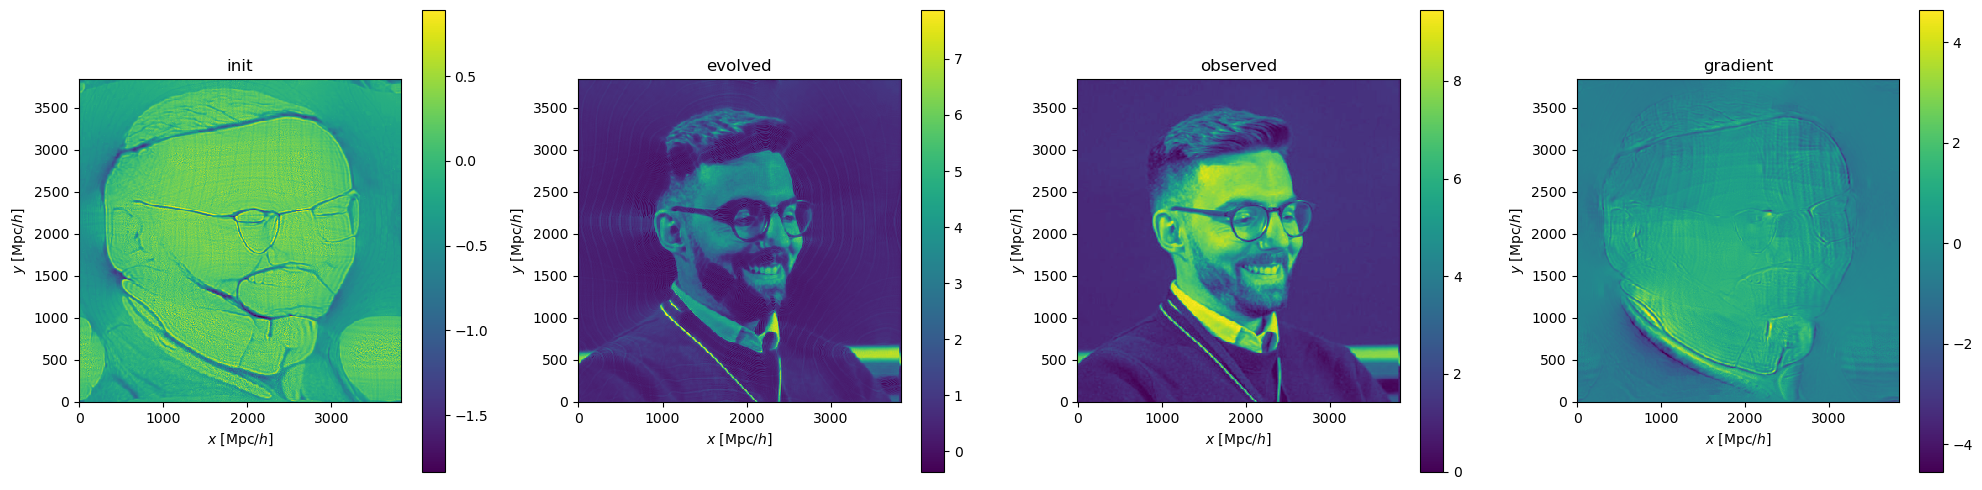

In [27]:
plt.figure(figsize=(6,4))
plt.plot(energies)
plt.xlabel("Epoch"), plt.ylabel("Potential")
plt.show()
anim, pm_mesh_mode = plot_optim_state(params)

In [12]:
anim.save('EiffL2.mp4', dpi=300, savefig_kwargs={'bbox_inches': "tight", 'pad_inches': 10})